In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random

In [3]:
df = pd.read_csv('data/crash_reporting_drivers_data_sanitized.csv')
df

/var/folders/1b/vcjnk6kd037gn7jddj1yk3_c0000gn/T/ipykernel_5303/4045090552.py:1: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('data/crash_reporting_drivers_data_sanitized.csv')


,Report Number,Local Case Number,Agency Name,ACRS Report Type,Crash Date/Time,Route Type,Road Name,Cross-Street Type,Cross-Street Name,Off-Road Description,...,Speed Limit,Driverless Vehicle,Parked Vehicle,Vehicle Year,Vehicle Make,Vehicle Model,Equipment Problems,Latitude,Longitude,Location
0,MCP3040003N,190026050,Montgomery County Police,Property Damage Crash,2019-05-31 03:00:00,NaN,NaN,NaN,NaN,PARKING LOT OF 3215 SPARTAN RD,...,15,No,No,2004-01-01,HONDA,TK,UNKNOWN,39.150044,-77.063089,"(39.15004368, -77.06308884)"
1,MCP1307000K,190024786,Montgomery County Police,Property Damage Crash,2019-05-24 05:00:00,NaN,NaN,NaN,NaN,PARKING LOT,...,0,No,No,2000-01-01,UNK,UNK,NaN,39.199047,-77.250743,"(39.19904667, -77.25074333)"
2,MCP2846008X,230034260,Montgomery County Police,Property Damage Crash,2023-07-17 10:45:00,County,SELFRIDGE RD,County,RANDOLPH RD,NaN,...,35,No,No,2003-01-01,FORD,TK,NO MISUSE,39.054588,-77.085974,"(39.05458848, -77.08597423)"
3,MCP32610017,230034668,Montgomery County Police,Property Damage Crash,2023-07-20 11:40:00,Maryland (State),MUNCASTER MILL RD,County,SHADY GROVE RD,NaN,...,45,No,No,2023-01-01,TOYOTA,CP,NO MISUSE,39.148721,-77.147111,"(39.14872076, -77.14711061)"
4,EJ78520081,230033429,Gaithersburg Police Depar,Property Damage Crash,2023-07-13 05:40:00,Municipality,PERRY PKWY,Unknown,ENT TO SHOPPING CENTER,NaN,...,25,No,No,2001-01-01,KENWORTH,TRUCK,NaN,39.149085,-77.210731,"(39.14908542, -77.21073135)"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
167794,DM8338000C,16010228,Takoma Park Police Depart,Property Damage Crash,2016-03-01 10:01:00,Municipality,NEW HAMPSHIRE SERVICE LA,Municipality,PRINCE GEORGES AVE,NaN,...,25,No,No,2016-01-01,FORD,EXPLORER,NO MISUSE,38.972560,-76.997466,"(38.97255976, -76.99746609)"
167795,MCP1182001S,170519976,Montgomery County Police,Property Damage Crash,2017-07-19 02:22:00,County,CEDAR LA,Maryland (State),OLD GEORGETOWN RD,NaN,...,35,No,No,2008-01-01,NISSAN,ALTIMA,NO MISUSE,39.004640,-77.108502,"(39.00464, -77.10850167)"
167796,MCP1453008X,200046217,Montgomery County Police,Property Damage Crash,2020-11-23 07:37:00,Maryland (State),RIDGE RD,Unknown,LITTLE SENECA PKWY,NaN,...,40,No,No,2008-01-01,CHEVROLET,EXPRESS,NO MISUSE,39.228963,-77.236757,"(39.22896333, -77.23675667)"
167797,MCP2568000M,190056701,Montgomery County Police,Property Damage Crash,2019-11-23 11:23:00,County,SHADY GROVE RD,Ramp,RAMP 9 FR IS 370 EB TO SHADY GROVE RD,NaN,...,35,No,No,2018-01-01,FORD,TRANSIT VAN,NO MISUSE,39.120440,-77.180047,"(39.12043995, -77.18004738)"


In [4]:
df.columns

Index(['Report Number', 'Local Case Number', 'Agency Name', 'ACRS Report Type',
       'Crash Date/Time', 'Route Type', 'Road Name', 'Cross-Street Type',
       'Cross-Street Name', 'Off-Road Description', 'Municipality',
       'Related Non-Motorist', 'Collision Type', 'Weather',
       'Surface Condition', 'Light', 'Traffic Control',
       'Driver Substance Abuse', 'Non-Motorist Substance Abuse', 'Person ID',
       'Driver At Fault', 'Injury Severity', 'Circumstance',
       'Driver Distracted By', 'Drivers License State', 'Vehicle ID',
       'Vehicle Damage Extent', 'Vehicle First Impact Location',
       'Vehicle Second Impact Location', 'Vehicle Body Type',
       'Vehicle Movement', 'Vehicle Continuing Dir', 'Vehicle Going Dir',
       'Speed Limit', 'Driverless Vehicle', 'Parked Vehicle', 'Vehicle Year',
       'Vehicle Make', 'Vehicle Model', 'Equipment Problems', 'Latitude',
       'Longitude', 'Location'],
      dtype='object')

### Utils

In [49]:
def display_unique_values(df,col, max=True):
    if col not in df.columns:
        print(f"{col} not in dataframe")
        return
    if not max:
        print(df[col].value_counts())
    else:
        with pd.option_context('display.max_rows', None, 'display.max_columns', None):
            print(df[col].value_counts())

    print(f"\nLength of Unique Values: {len(df[col].value_counts())}")
    print(f"\nColumn Length: {len(df[col])}")
    print('NA values: ', df[col].isna().sum())

# Defining colors, background, style and fonts for all the plots
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']
fonts = ['Arial', 'Calibri', 'Times New Roman', 'Verdana', 'Helvetica']
styles = ['whitegrid', 'dark', 'white', 'ticks']
backgrounds = ['white', 'lightgray', 'lightblue', 'lightyellow', 'lightgreen']

## BAR CHARTS

In [51]:
def plot_bar_chart(column_name, title, xlabel, ylabel):
    # Randomly select a color, font, style, and background
    color = random.choice(colors)
    style = 'darkgrid'
    background = 'darkgray'

    sns.set(style=style)  # Set the style of the plot
    # plt.rcParams["font.family"] = font  # Set the font of the plot
    plt.figure(figsize=(10, 6))  # Set the size of the plot

    # Plot the bar chart
    ax = df[column_name].value_counts().plot(kind='bar', color=color)

    # Set the title, x-label, and y-label
    ax.set_title(title, fontsize=14, fontweight='bold')
    ax.set_xlabel(xlabel, fontsize=12)
    ax.set_ylabel(ylabel, fontsize=12)

    # Rotate x-axis labels for better readability
    plt.xticks(rotation=45)

    # Set the background color
    ax.set_facecolor(background)

    # Show the plot
    plt.show()

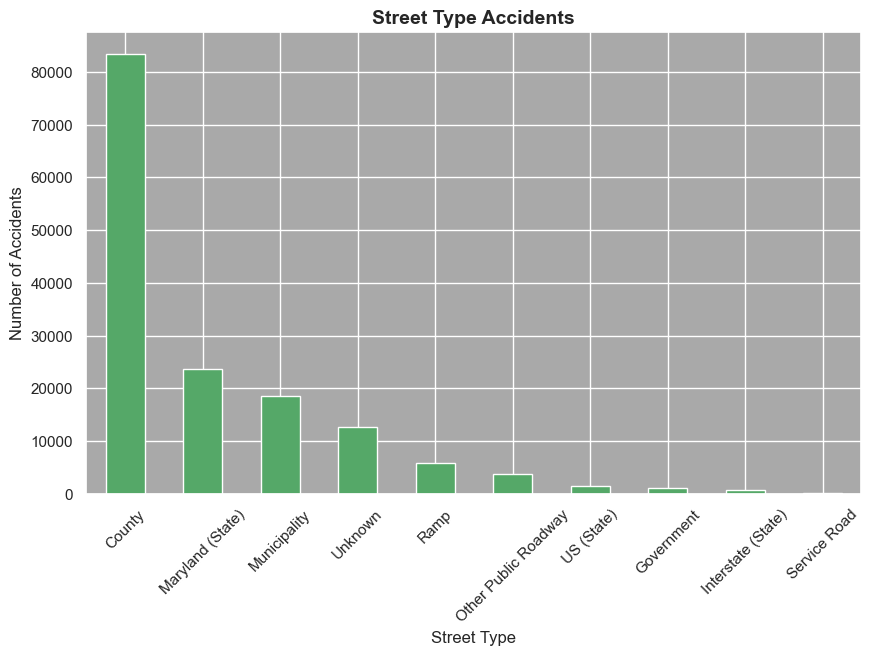

Cross-Street Type
County                  83448
Maryland (State)        23693
Municipality            18564
Unknown                 12678
Ramp                     5768
Other Public Roadway     3714
US (State)               1449
Government               1150
Interstate (State)        662
Service Road               91
Name: count, dtype: int64

Length of Unique Values: 10

Column Length: 167799
NA values:  16582


In [52]:
plot_bar_chart(
    column_name="Cross-Street Type",
    title="Street Type Accidents",
    xlabel="Street Type",
    ylabel="Number of Accidents"
    )

display_unique_values(df, 'Cross-Street Type')

## Frequency Analysis

In [175]:
def plot_stacked_bar_chart(column_name, stacked_column, title, xlabel, ylabel, show_values=False):
    # Randomly select a color, font, style, and background
    color = random.choice(colors)
    fonts = "Helvetica"
    style = 'darkgrid'
    background = "lightgray"
    # color_palette = sns.color_palette("Set2", len(df[column_name].unique()))  # dark, muted, pastel, bright, deep, colorblind
    # color_palette = sns.hls_palette(len(df[column_name].unique()))
    # color_palette = sns.color_palette("viridis", len(df[column_name].unique()))
    color_palette = sns.color_palette("tab20", len(df[column_name].unique()))

    sns.set(style=style)  # Set the style of the plot
    # plt.rcParams["font.family"] = font  # Set the font of the plot
    plt.figure(figsize=(10, 6))  # Set the size of the plot

    # Plot the bar chart
    ax = df.groupby(column_name)[stacked_column].value_counts().unstack().plot(kind='bar', stacked=True, color=color_palette)

    # Set the title, x-label, and y-label
    ax.set_title(title, fontsize=14, fontweight='bold')
    ax.set_xlabel(xlabel, fontsize=12)
    ax.set_ylabel(ylabel, fontsize=12)

    # Move the legend to the right side of the plot
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

    # Add data labels to the stacked bar chart
    if show_values:
        for p in ax.patches:
            width, height = p.get_width(), p.get_height()
            x, y = p.get_xy()
            ax.annotate(f'{height}', (x + width/2, y + height/2), ha='center', va='center')

    # Rotate x-axis labels for better readability
    plt.xticks(rotation=45)

    # Set the background color
    ax.set_facecolor(background)

    # Show the plot
    plt.show()

### Combination 1 : 1) ACRS Report Type x Route Type

<Figure size 1000x600 with 0 Axes>

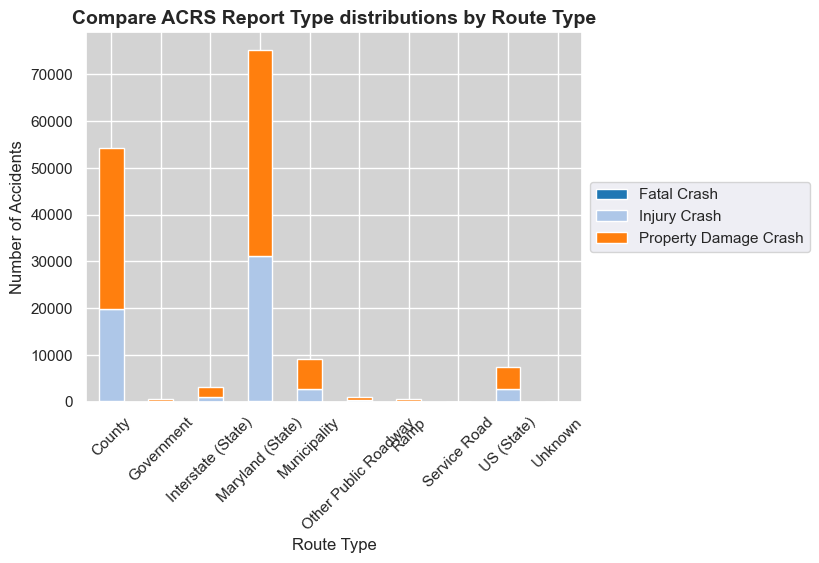

In [178]:
# Bar chart stacked by Route Type to compare ACRS Report Type distributions.
plot_stacked_bar_chart("Route Type", "ACRS Report Type", "Compare ACRS Report Type distributions by Route Type", "Route Type", "Number of Accidents")

### Combination 1 : 2)Weather x Surface Condition

In [116]:
def scatter_plots(column_name, title, xlabel, ylabel, size_column, color_column, data=df): ## For numerical data
    # Randomly select a color, font, style, and background
    color = random.choice(colors)
    style = 'darkgrid'
    background = random.choice(backgrounds)

    sns.set(style=style)  # Set the style of the plot
    # plt.rcParams["font.family"] = font  # Set the font of the plot
    plt.figure(figsize=(10, 6))  # Set the size of the plot

    # Plot the bubble chart
    ax = sns.scatterplot(x=column_name, y=size_column, size=size_column, hue=color_column, data=df)

    # Set the title, x-label, and y-label
    ax.set_title(title, fontsize=14, fontweight='bold')
    ax.set_xlabel(xlabel, fontsize=12)
    ax.set_ylabel(ylabel, fontsize=12)

    # Move the legend to the right side of the plot
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

    # Rotate x-axis labels for better readability
    plt.xticks(rotation=45)
    
    # Set the background color
    ax.set_facecolor(background)

    # Show the plot
    plt.show()

def balloon_plot(x_column, y_column, title, xlabel, ylabel, data=df, size_column=None, color_column=None, size=(50, 500), rotation=45):
    # Randomly select a color, style, and background
    style = 'darkgrid'
    background = 'darkgray'
    color_palette = None if color_column is None else sns.color_palette("Set2", len(df[color_column].unique()))

    # sns.set(style=style)  # Set the style of the plot
    plt.figure(figsize=(10, 6))  # Set the size of the plot

    # Plot the balloon chart
    if size_column is None and color_column is None:
        ax = sns.scatterplot(x=x_column, y=y_column, data=data)
    elif size_column is None:
        ax = sns.scatterplot(x=x_column, y=y_column, hue=color_column, data=data, palette=color_palette)
    elif color_column is None:
        ax = sns.scatterplot(x=x_column, y=y_column, size=size_column, sizes=size, data=data)
    else:
        ax = sns.scatterplot(x=x_column, y=y_column, size=size_column, hue=color_column, sizes=size, data=data, palette=color_palette)

    # Set the title, x-label, and y-label
    ax.set_title(title, fontsize=14, fontweight='bold')
    ax.set_xlabel(xlabel, fontsize=12)
    ax.set_ylabel(ylabel, fontsize=12)

    # Move the legend to the right side of the plot
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

    # Rotate x-axis labels for better readability
    plt.xticks(rotation=rotation)
    
    # Set the background color
    ax.set_facecolor(background)

    # Show the plot
    plt.show()

/var/folders/1b/vcjnk6kd037gn7jddj1yk3_c0000gn/T/ipykernel_5303/3202249067.py:48: UserWarning: The palette list has more values (12) than needed (6), which may not be intended.
  ax = sns.scatterplot(x=x_column, y=y_column, size=size_column, hue=color_column, sizes=size, data=data, palette=color_palette)


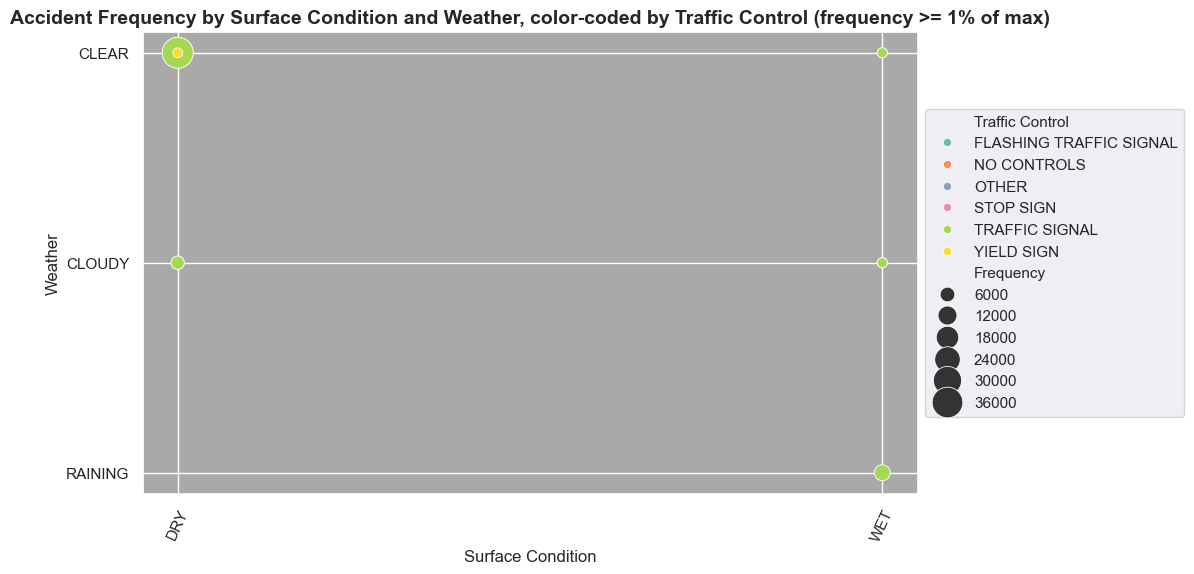

Surface Condition  Weather  Traffic Control          Frequency
DRY                CLEAR    FLASHING TRAFFIC SIGNAL  1243         1
                            NO CONTROLS              36489        1
                            OTHER                    1138         1
                            STOP SIGN                7387         1
                            TRAFFIC SIGNAL           36992        1
                            YIELD SIGN               1081         1
                   CLOUDY   NO CONTROLS              4436         1
                            STOP SIGN                1021         1
                            TRAFFIC SIGNAL           4274         1
WET                CLEAR    NO CONTROLS              1298         1
                            TRAFFIC SIGNAL           1132         1
                   CLOUDY   NO CONTROLS              1406         1
                            TRAFFIC SIGNAL           1255         1
                   RAINING  NO CONTROLS              

In [117]:
# Bubble chart with bubble size proportional to accident frequency, color-coded by Traffic Control, and positioned based on Surface Condition and Light.
df_12 = df.groupby(['Surface Condition', 'Weather', 'Traffic Control']).size().reset_index(name='Frequency')
df_12_filtered = df_12[df_12['Frequency'] >= 0.01 * df_12['Frequency'].max()]
df_12_filtered
# df_12

balloon_plot(
    x_column='Surface Condition',
    y_column='Weather', 
    title='Accident Frequency by Surface Condition and Weather, color-coded by Traffic Control (frequency >= 1% of max)', 
    xlabel='Surface Condition', 
    ylabel='Weather', 
    size_column='Frequency',
    color_column='Traffic Control',
    rotation=65,
    data=df_12_filtered
    )
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    # print(df_12.value_counts())
    print(df_12_filtered.value_counts())

### Combination 1 : 3) Drivers at fault vs substance abuse for both drivers and non-motorists.

In [164]:
# Pie chart or stacked bar chart to visualize the proportion of drivers at fault, with suspected substance abuse for both drivers and non-motorists.

def pie_chart(column_name1, column_name2, title, data=df):
    # Randomly select a color, font, style, and background
    # color = random.choice(colors)
    # style = 'darkgrid'
    # background = 'darkgray'

    # sns.set(style=style)  # Set the style of the plot
    # plt.rcParams["font.family"] = font  # Set the font of the plot
    plt.figure(figsize=(10, 6))  # Set the size of the plot

    # Plot the pie chart
    ax = df.groupby([column_name1, column_name2]).size().unstack().plot(kind='pie', subplots=True, autopct='%1.1f%%', startangle=90)

    # Set the title
    ax.set_title(title, fontsize=14, fontweight='bold')

    # Set the background color
    # ax.set_facecolor(background)

    # Show the plot
    plt.show()

In [166]:
# pie_chart(
#     column_name1='Driver Substance Abuse',
#     column_name2='Non-Motorist Substance Abuse',
#     title='Proportion of drivers at fault, with suspected substance abuse for both drivers and non-motorists'
#     )

/var/folders/1b/vcjnk6kd037gn7jddj1yk3_c0000gn/T/ipykernel_5303/1967197773.py:25: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r--" (-> color='r'). The keyword argument will take precedence.
  plt.plot(df.set_index(datetime_column).resample('M').size(), "r--", color='black')


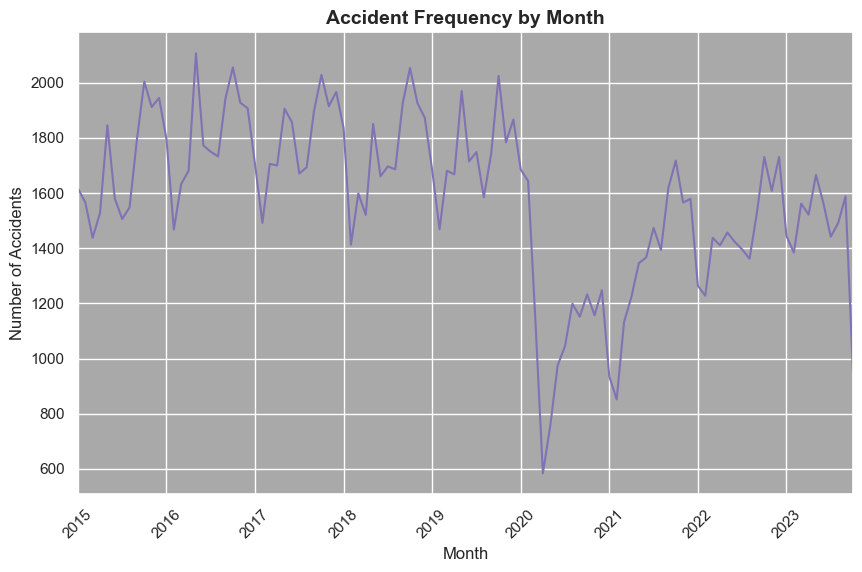

In [170]:
def plot_line_chart(datetime_column, title, xlabel, ylabel):
    # Randomly select a color, font, style, and background
    color = random.choice(colors)
    style = 'darkgrid'
    background = 'darkgray'

    sns.set(style=style)  # Set the style of the plot
    # plt.rcParams["font.family"] = font  # Set the font of the plot
    plt.figure(figsize=(10, 6))  # Set the size of the plot

    # Convert the datetime column to a pandas datetime object
    df[datetime_column] = pd.to_datetime(df[datetime_column])

    # Plot the line chart
    ax = df.set_index(datetime_column).resample('M').size().plot(kind='line', color=color)

    # Set the title, x-label, and y-label
    ax.set_title(title, fontsize=14, fontweight='bold')
    ax.set_xlabel(xlabel, fontsize=12)
    ax.set_ylabel(ylabel, fontsize=12)

    # # Add a trendline
    # z = np.polyfit(range(len(df)), df.set_index(datetime_column).resample('M').size(), 1)
    # p = np.poly1d(z)
    plt.plot(df.set_index(datetime_column).resample('M').size(), "r--", color='black')

    # Rotate x-axis labels for better readability
    plt.xticks(rotation=45)

    # Set the background color
    ax.set_facecolor(background)

    # Show the plot
    plt.show()

plot_line_chart(
    datetime_column='Crash Date/Time',
    title='Accident Frequency by Month',
    xlabel='Month',
    ylabel='Number of Accidents'
)
